In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
from Updating_LieDrivative import *


In [18]:
# System Dynamic 
def Oscillator(x, t, a=1.0, b=3.0):
    dx = np.zeros(2)
    dx[0] = a + x[0]**2 * x[1] - b*x[0] - x[0]
    dx[1] = b * x[0] - x[0]**2 * x[1]
    return dx

def OscillatorMeasurement(x):
    y = np.zeros(1)
    y[0] = x[0] + x[1]
    return y

In [19]:

class Plant:
    def __init__(self, nx, ny, dynamics=Oscillator, measurement=OscillatorMeasurement):
        self.nx = nx
        self.ny = ny
        self.dynamics = dynamics
        self.measurement = measurement
        self.x = np.zeros(nx)
        self.y = self.measurement(self.x)
    def initialize(self, x0):
        self.x = x0
        self.y = self.measurement(self.x)
    def move_forward(self, t=0.0, dt=1.0):
        self.x += dt * self.dynamics(self.x, t)
        self.y = self.measurement(self.x)


class Observer:
    def __init__(self, nx, ny, maxlength=3, horizon=10):
        self.nx = nx
        self.ny = ny
        self.maxlength = maxlength
        self.horizon = horizon
        self.x = np.zeros(nx)
        self.xhistory = np.zeros((self.horizon + 1, self.nx))
        self.y = np.zeros(ny)
        self.yhistory = np.zeros((self.horizon + 1, self.ny))
        self.series = []
        
    def create(self):
        for i in range(self.nx):
            newseries = Series(self.maxlength, self.ny, self.horizon)
            self.series.append(newseries)
                
    def measure(self, plant):
        self.x = plant.x
        self.xhistory = np.delete(self.xhistory, 0, axis=0)
        self.xhistory = np.vstack([self.xhistory, self.x])
        self.y = plant.y
        self.yhistory = np.delete(self.yhistory, 0, axis=0)
        self.yhistory = np.vstack([self.yhistory, self.y])
    
        
    def initialize(self, dt=1.0):
        for i in range(self.nx):
            obj = self.series[i].initialization_at_unity(self.xhistory[:,i], self.yhistory, dt)
    
    def update(self, rates, dt = 1.0):
        obj_old_vec = np.zeros(self.nx)
        obj_new_vec = np.zeros(self.nx)
        xobs_vec = np.zeros(self.nx)
        for i in range(self.nx):
            obj_old, obj_new = self.series[i].gradient_update(self.xhistory[:,i], self.yhistory, rates[i], dt)
            obj_old_vec[i] = obj_old
            obj_new_vec[i] = obj_new
            xobs = self.series[i].observe()
            xobs_vec[i] = xobs
        return obj_old_vec, obj_new_vec, xobs_vec

In [59]:
# Designing Observer's Hyperparameters

number_x = 2
number_y = 1
dynamics = Oscillator
measurement = OscillatorMeasurement
dt = 0.01
Nt = 5000
observerrateconstant = 1
observermaxlength = 3
observerhorizon = 10
observerwaittime = 0
observerrates = number_x * [observerrateconstant / dt]


plant = Plant(number_x, number_y, Oscillator, OscillatorMeasurement)
observer = Observer(number_x, number_y, observermaxlength, observerhorizon)
observer.create()

Nt = Nt + observerhorizon + observerwaittime -1
xtrajectory = np.zeros((Nt + 1, number_x))
ytrajectory = np.zeros((Nt + 1, number_y))
principalstrajectory = np.zeros((Nt + 1, number_x))
principalsposteriortrajectory = np.zeros((Nt + 1, number_x))
xobstrajectory = np.zeros((Nt + 1, number_x))
Joldtrajectory = np.zeros((Nt + 1, number_x))
Jnewtrajectory = np.zeros((Nt + 1, number_x))



In [60]:
# Updating Simulation
x0 = np.array([1.0, 1.0])
plant.initialize(x0)
xtrajectory[0, :] = plant.x
ytrajectory[0, :] = plant.y
observer.initialize(dt)
J = 0
observerwaittime = 0

for count in range(1, Nt + 1):
    plant.move_forward(dt * count, dt)
    xtrajectory[count, :] = plant.x
    ytrajectory[count, :] = plant.y

    if count >=  (observerhorizon + observerwaittime):
        observer.measure(plant)
        obj_old_vec, obj_new_vec, xobs_vec = observer.update(observerrates, dt)
        Joldtrajectory[count, :] = obj_old_vec
        Jnewtrajectory[count, :] = obj_new_vec
        xobstrajectory[count, :] = xobs_vec

    if (count % 100 == 0):
        print('Sampling time', count)

for tcount in range(observerhorizon + observerwaittime, Nt + 1):
    J += np.linalg.norm(xobstrajectory[tcount, :] - xtrajectory[tcount, :], 2)**2 

J = np.sqrt(J/(Nt + 1 - observerhorizon - observerwaittime))
print(J)

Sampling time 100
Sampling time 200
Sampling time 300
Sampling time 400
Sampling time 500
Sampling time 600
Sampling time 700
Sampling time 800
Sampling time 900
Sampling time 1000
Sampling time 1100
Sampling time 1200
Sampling time 1300
Sampling time 1400
Sampling time 1500
Sampling time 1600
Sampling time 1700
Sampling time 1800
Sampling time 1900
Sampling time 2000
Sampling time 2100
Sampling time 2200
Sampling time 2300
Sampling time 2400
Sampling time 2500
Sampling time 2600
Sampling time 2700
Sampling time 2800
Sampling time 2900
Sampling time 3000
Sampling time 3100
Sampling time 3200
Sampling time 3300
Sampling time 3400
Sampling time 3500
Sampling time 3600
Sampling time 3700
Sampling time 3800
Sampling time 3900
Sampling time 4000
Sampling time 4100
Sampling time 4200
Sampling time 4300
Sampling time 4400
Sampling time 4500
Sampling time 4600
Sampling time 4700
Sampling time 4800
Sampling time 4900
Sampling time 5000
0.36425779533321


C:\Users\Ashkan\AppData\Local\Temp\ipykernel_107240\506622734.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(number_x, 1, i+1)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


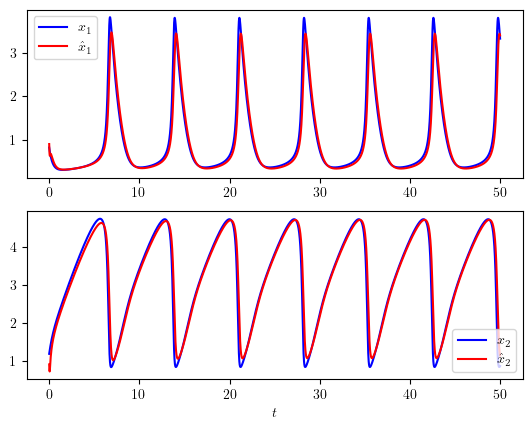

In [61]:
# Plotting

trange = np.arange(Nt + 1 - observerhorizon - observerwaittime) * dt

fig, ax = plt.subplots()
for i in range(number_x):
    ax = plt.subplot(number_x, 1, i+1)
    ax.plot(trange, xtrajectory[observerhorizon + observerwaittime:, i], 'b', label=r'$x_{%s}$' % (i+1))
    ax.plot(trange, xobstrajectory[observerhorizon + observerwaittime:, i], 'r', label=r'$\hat{x}_{%s}$' % (i+1))
    ax.legend()

    if i == number_x - 1:
        ax.set_xlabel(r'$t$')

figurename = 'one'
fig.savefig(figurename, format='eps', dpi=1200)
plt.show()
